In [547]:
import jax.numpy as jnp
from jax import random, vmap
from jax.scipy.special import logsumexp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS

/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


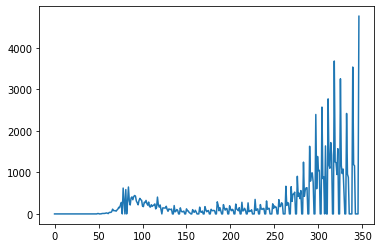

In [577]:
import pandas as pd
import numpy as np
DATA_URI = "https://raw.githubusercontent.com/reichlab/covid19-forecast-hub/master/data-truth/truth-Incident%20Cases.csv"

df = pd.read_csv(DATA_URI)

DATA_URI = "https://raw.githubusercontent.com/reichlab/covid19-forecast-hub/master/data-truth/truth-Incident%20Deaths.csv"


df_deaths = pd.read_csv(DATA_URI)


cases=df[df.location_name=="Rhode Island"]
deaths=df_deaths[df_deaths.location_name=="Rhode Island"]
joined_df = cases.set_index('date').join(deaths.set_index('date'),how='left',lsuffix='cases',rsuffix='deaths')
plt.plot(cases.value.values)

In [576]:
cases

,date,location,location_name,value
5,2020-01-24,06,California,0
62,2020-01-25,06,California,0
119,2020-01-26,06,California,2
176,2020-01-27,06,California,0
233,2020-01-28,06,California,0
290,2020-01-29,06,California,0
347,2020-01-30,06,California,0
404,2020-01-31,06,California,1
461,2020-02-01,06,California,0
518,2020-02-02,06,California,0


In [580]:
import patsy
import numpy as np

df_full = pd.DataFrame({'X':np.arange(len(joined_df.valuecases.tolist())),
                   'Y':np.array(joined_df.valuecases.tolist()),  # add your data here
                    'D': np.array(joined_df.valuedeaths.tolist())})
                  
df_train =df_full

df_train.Y=df_train.Y.replace(0, np.NaN).interpolate()

df_train.D= df_train.D.replace(0, np.NaN).interpolate()




B = patsy.dmatrix('bs(X, knots=np.arange(df_train.X.values[0],df_train.X.values[-1]+27,20), degree=3)', df_train, 
                  return_type='matrix')

num_data, num_basis = B.shape
print (B.shape)

ValueError: some knot values ([360]) fall above upper bound (346)

In [550]:
def exp_pdf(lambda_,x):
    return (lambda_*np.exp(-lambda_*x))

In [551]:
df_train.D

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
5        0.0
6        0.0
7        0.0
8        0.0
9        0.0
10       0.0
11       0.0
12       0.0
13       0.0
14       0.0
15       0.0
16       0.0
17       0.0
18       0.0
19       0.0
20       0.0
21       0.0
22       0.0
23       0.0
24       0.0
25       0.0
26       0.0
27       0.0
28       0.0
29       0.0
30       0.0
31       0.0
32       0.0
33       0.0
34       0.0
35       0.0
36       0.0
37       0.0
38       0.0
39       0.0
40       1.0
41       1.0
42       1.0
43       1.0
44       1.0
45       1.0
46       1.0
47       2.0
48       2.0
49       2.0
50       2.0
51       2.0
52       2.0
53       5.0
54       4.0
55       2.0
56       6.0
57       1.0
58       5.0
59       9.0
60      11.0
61      15.0
62      16.0
63      13.0
64      16.0
65      14.0
66      22.0
67      27.0
68      26.0
69      39.0
70      27.0
71      24.0
72      59.0
73      32.0
74      52.0
75      63.0
76      49.0

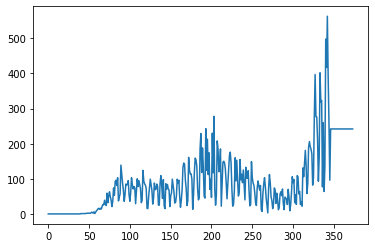

In [552]:
plt.plot(df_train.D.values)

In [553]:
import sys
np.set_printoptions(threshold=sys.maxsize)
import math
# building the expnential distribution mask
lambda_ = 21
mask = np.zeros((num_data,num_data))
for i in np.arange(num_data):
    tmp=np.flip(exp_pdf(21,np.arange(num_data))[:(i+1)])
    mask[i,:(i+1)]=tmp
        


In [554]:
def LogisticRandomWalk(loc=1., scale=1e-2, drift=0., num_steps=100):
    '''
    Return distrubtion of exponentiated Gaussian random walk
   
    Variables are x_0, ..., x_{T-1}
   
    Dynamics in log-space are random walk with drift:
       log(x_0) := log(loc)
       log(x_t) := log(x_{t-1}) + drift + eps_t,    eps_t ~ N(0, scale)
    
    ==> Dynamics in non-log space are:
        x_0 := loc
        x_t := x_{t-1} * exp(drift + eps_t),    eps_t ~ N(0, scale)
    '''
   
    logistic_loc = np.log(loc/(1-loc)) + drift * (np.arange(num_steps)+0.)
   
    return dist.TransformedDistribution(
        dist.GaussianRandomWalk(scale=scale, num_steps=num_steps),
        [
            dist.transforms.AffineTransform(loc = logistic_loc, scale=1.),
            dist.transforms.SigmoidTransform()
        ]
    )

In [567]:

def model(B_local=None,Forecast=False,Forecast_det_prob=None,mask=None):
    if Forecast==False:
        det_prob = numpyro.sample("det_prob",
                                      LogisticRandomWalk(loc=.01, 
                                                         scale=5e-2, 
                                                         drift=0.,
                                                         num_steps=num_data))
    
    else:
        det_prob=Forecast_det_prob
    a_raw =numpyro.sample('a_raw',dist.Normal(jnp.zeros(num_basis),1000*jnp.ones(num_basis)))
    sigma = numpyro.sample('sigma', dist.Exponential(10))
    sigma2 = numpyro.sample('sigma2', dist.Exponential(100))

    y_hat =  numpyro.deterministic('c', jnp.dot(jnp.array(B_local), a_raw))
    y = numpyro.sample('y', dist.Normal(y_hat, sigma2), obs=df_train.Y.values)
   
    y_hat_masked = jnp.matmul(mask,y_hat)
    d_hat = jnp.flip(numpyro.deterministic('d', det_prob*y_hat_masked))
  
    #print (np.transpose(y_hat_tiled))

    numpyro.sample('d_obs', dist.Normal(det_prob*y_hat_masked, sigma), obs=df_train.D.values)

    #numpyro.sample('d',dist.Normal(d_hat,10),obs=df_train.D)

In [568]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

num_warmup, num_samples = 1000, 2000

# Run NUTS.
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup, num_samples)
mcmc.run(rng_key_,B_local=B,Forecast=False,Forecast_det_prob=None,mask=mask)
mcmc.print_summary()
samples_1 = mcmc.get_samples()

sample: 100%|██████████| 3000/3000 [01:18<00:00, 38.03it/s, 127 steps of size 7.29e-02. acc. prob=0.84] 



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
     a_raw[0]   9590.34    205.78   9585.07   9259.22   9932.53   1172.41      1.00
     a_raw[1]  -9526.16    226.33  -9521.51  -9881.60  -9153.05   1232.50      1.00
     a_raw[2]  -9615.08    236.83  -9611.08  -9998.71  -9221.34   1276.00      1.00
     a_raw[3]  -9473.19    251.35  -9468.13  -9857.43  -9048.97   1376.57      1.00
     a_raw[4]  -9693.26    243.15  -9690.99 -10073.79  -9270.87   1302.44      1.00
     a_raw[5]  -9274.91    250.48  -9273.42  -9715.78  -8906.17   1344.15      1.00
     a_raw[6]  -7801.55    252.31  -7794.28  -8259.40  -7412.87   1343.29      1.00
     a_raw[7]  -8230.57    250.75  -8222.09  -8626.10  -7815.86   1408.96      1.00
     a_raw[8]  -6930.75    254.97  -6928.75  -7317.00  -6486.18   1474.97      1.00
     a_raw[9]  -7587.12    255.08  -7591.63  -7980.57  -7146.46   1357.68      1.00
    a_raw[10]  -1632.39    253.77  -1634.72  -2023.06  -1197.71   1370.40  

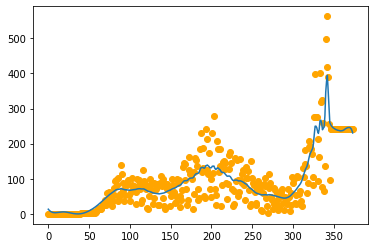

In [569]:
plt.plot(df_train.X.values,samples_1['d'].mean(axis=0))
plt.scatter(df_train.X.values,df_train.D.values,color='orange')

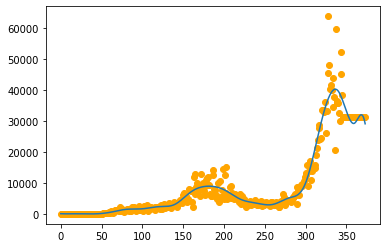

In [570]:
plt.plot(df_train.X.values,samples_1['c'].mean(axis=0))
plt.scatter(df_train.X.values,df_train.Y.values,color='orange')

In [571]:
lambda_ = 21
forecast_mask = np.zeros((27,27))
for i in np.arange(27):
    for j in np.arange(27):
        if j-i >=0:
            tmp = exp_pdf(lambda_,np.abs(i-j))
            if math.isinf(tmp):
                forecast_mask[27-i-1,j] = 0
            else:
                forecast_mask[27-i-1,j] = tmp
        else:
            forecast_mask[27-i-1,j] = 0
        

In [572]:
new_data = {"X":np.arange(df_train.X.values[-1]-27,df_train.X.values[-1],1)}

B_predict = patsy.build_design_matrices([B.design_info], new_data)[0]
from numpyro.infer import Predictive
det_prob_forecast= samples_1['det_prob'].mean(axis=0)[-1]
predictive = Predictive(model, samples_1)
predictions = predictive(rng_key_,B_local=B_predict,Forecast=True,Forecast_det_prob=det_prob_forecast,mask=forecast_mask)['d']


In [573]:
predictions.shape

(2000, 27)

401


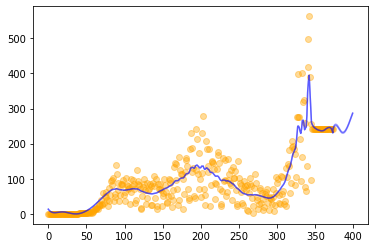

In [574]:
full_mean = np.concatenate((samples_1['d'].mean(axis=0),predictions.mean(axis=0)))
full_upq = np.concatenate((samples_1['d'].mean(axis=0),np.quantile(predictions,.975,axis=0)))
full_lrq = np.concatenate((samples_1['d'].mean(axis=0),np.quantile(predictions,.025,axis=0)))

print (len(full_upq))
full_mean_x = np.concatenate((df_train.X.values,np.arange(df_train.X.values[-1],df_train.X.values[-1]+27)))
#plt.plot(full_mean_x,full_mean)
plt.scatter(df_train.X.values,df_train.D.values,color='orange',alpha=.4)
plt.plot(full_mean_x,full_upq,color='blue',alpha=.4)
plt.plot(full_mean_x,full_lrq,color='blue',alpha=.4)



/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in exp
  """Entry point for launching an IPython kernel.


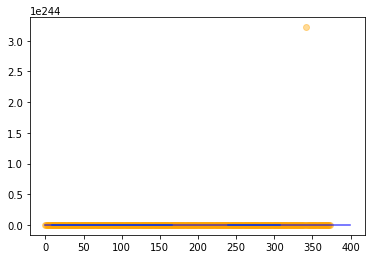

In [563]:
plt.plot(full_mean_x,np.exp(full_mean))
plt.scatter(df_train.X.values,np.exp(df_train.D.values),color='orange',alpha=.4)
plt.plot(full_mean_x,np.exp(full_upq),color='blue',alpha=.4)
plt.plot(full_mean_x,np.exp(full_lrq),color='blue',alpha=.4)